# Running stardist in Krakatoa with a GPU

Based on jupyeter labs provided by stardist

Marcnol, UPDATED MAR 2022 for drosophila embryo cells

# Packages

In [89]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage.measure import label, regionprops, regionprops_table
import os
from glob import glob
from tifffile import imread

### Check CUDA version and GPU

In [38]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:08:53_PST_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0
Tue May 17 09:28:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   40C    P8    11W / 320W |      8MiB / 11178MiB |      0%      Default |
|                               |       

### Select which GPU to perfom the calculations on

In [39]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" # OS environ is a list of variable in the working environment
#When changing CUDA VISIBLE you are hiding GPUs so in a way selecting the other (only works if you have 2 GPUs)


# Import the images

In [111]:
raw= imread("/mnt/tronador/jupyter//training_dataset/rt_simulation_3D/Best_simulations/2021-06-11_10-54/Training_data_thresh_2_Deconvolved/test/raw/11_raw.tif")


lab = imread('/mnt/tronador/jupyter/training_dataset/rt_simulation_3D/Best_simulations/2021-06-11_10-54/Training_data_thresh_2_Deconvolved/test/label/11_label.tif')

print(raw.shape)


print(lab.shape)

(30, 256, 256)
(30, 256, 256)


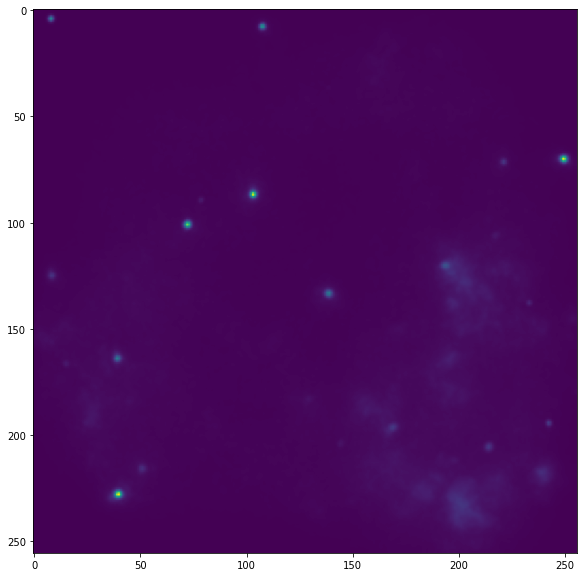

In [112]:
figure(figsize=(10,10))
plt.imshow(np.max(raw,axis=0))

# Plot the different metrics

In [113]:
regions = regionprops(lab,raw)

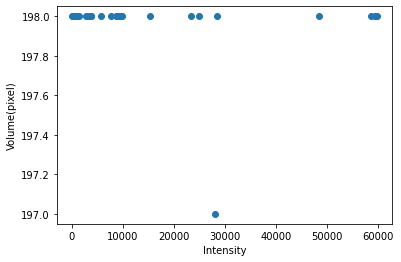

In [114]:
intensity = []
area = []
for i in range(len(regions)):
    intensity.append(regions[i].intensity_max)
    area.append(regions[i].area)

plt.scatter(intensity,area)
plt.xlabel('Intensity')
plt.ylabel('Volume(pixel)')
plt.show()

# Put all the properties in a dataframe to make the ploting easier

In [80]:
properties = ['label', 'area','intensity_max','intensity_mean','centroid_weighted']

region = regionprops_table(lab,intensity_image=raw,properties = properties)
df = pd.DataFrame(region)

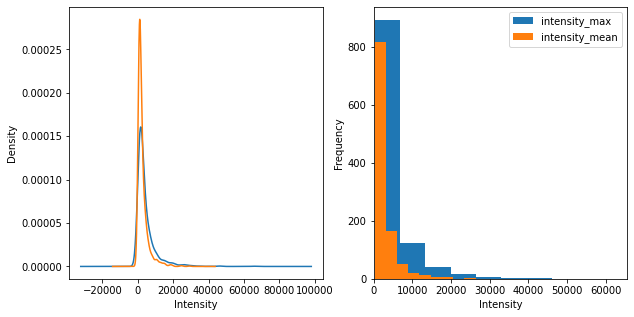

In [81]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
df.intensity_max.plot(kind='kde',label='intensity_max',ax=ax[0])
df.intensity_mean.plot(kind='kde',label='intensity_mean',ax = ax[0])
df.intensity_max.plot(kind='hist',label='intensity_max',ax=ax[1])
df.intensity_mean.plot(kind='hist',label='intensity_mean',ax = ax[1])
ax[0].set_xlabel('Intensity')
ax[1].set_xlabel('Intensity')
plt.xlim(0,np.max(raw))
plt.legend()
plt.show()

When plotting the intensity max and the average intenisty you see that when considering the mean the distribution is centered around 0. It comes from the fact that most labels are detected in several planes and some of those planes are out of focus thus the intensity is lower and furthermore the mean is smaller. It confirms that the max_intensity is a better metric to study the detected objects. 

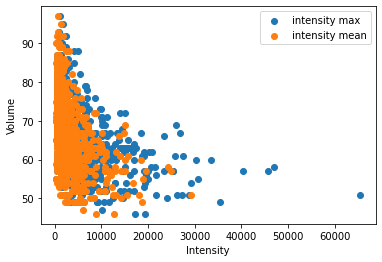

In [82]:
plt.scatter(df.intensity_max.values,df.area.values,label="intensity max")
plt.scatter(df.intensity_mean.values,df.area.values,label="intensity mean")
plt.legend()
plt.xlabel('Intensity')
plt.ylabel('Volume')
plt.show()

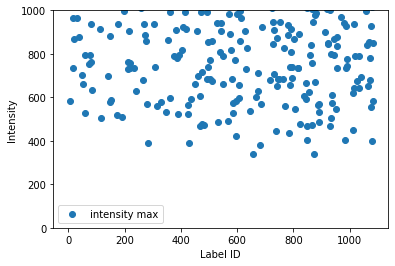

In [83]:
plt.scatter(df.label.values,df.intensity_max.values,label="intensity max")
#plt.scatter(df.intensity_mean.values,df.area.values,label="intensity mean")
plt.legend()
plt.ylim(0,1000)
plt.xlabel('Label ID')
plt.ylabel('Intensity')
plt.show()

# Iterate over different images

In [51]:
import time

4362.229916897507
5090.5508559919435
8081.079952267303
0.5007551431655883 min


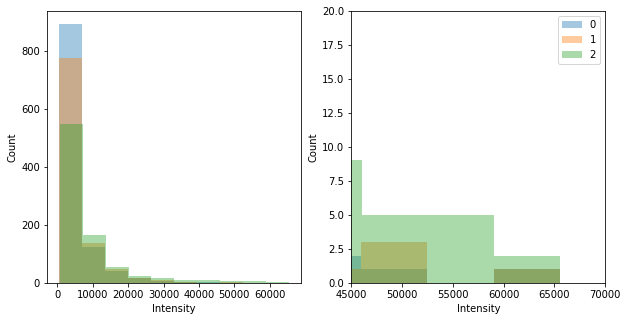

In [84]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

s = time.time()

file_list_r = [x for x in glob('Outputs/raw/data_christophe/untouched/'+os.sep+"*.npy") if "00" in x and "ch00" in x]
file_list_l = [x for x in glob('Outputs/labeled/data_christophe/retrained_network_V2bis/'+os.sep+"*.npy") if "00" in x and "ch00" in x]

counter = 0

for i,j in zip(file_list_r,file_list_l):
    intensity = []
    region = 0
    lab = np.load(j)
    im = np.load(i)
    region = regionprops(lab,im)
    for k in range(len(region)):
        intensity.append(region[k].intensity_max)
    print(np.mean(intensity))
    ax[0].hist(intensity,label = counter ,alpha= 0.4)
    ax[1].hist(intensity,label = counter ,alpha= 0.4)
    ax[1].set_xlim(45000,70000)
    ax[1].set_ylim(0,20)
    counter += 1
    
end = time.time() - s 

print(str(end/60)+ ' min')

    
ax[0].set_xlabel('Intensity')
ax[1].set_xlabel('Intensity')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
plt.legend()
plt.show()


## Comparisson of another segmentation network

4128.458620689656
219.01063829787233
207.85281385281385
220.57543103448276
219.4071729957806
290.9301310043668
408.14579055441476
628.3784355179704
724.784735812133
633.2935982339956
761.1530172413793
296.69604316546764
3.0932065924008687 min


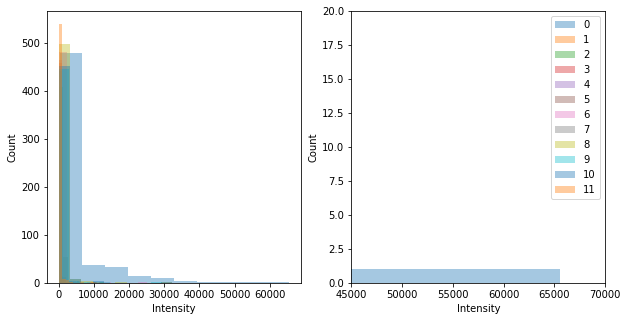

In [150]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

s = time.time()

file_list_l = [x for x in glob('../Ali/segmentations/npy_labels/'+os.sep+"*.npy") if "00" in x and "ch00" in x]
file_list_r = [x for x in glob('../Ali/segmentations/npy_images/'+os.sep+"*.npy") if "00" in x and "ch00" in x]

counter = 0

for i,j in zip(file_list_r,file_list_l):
    intensity = []
    region = 0
    lab = np.load(j)
    im = np.load(i)
    region = regionprops(lab,im)
    for k in range(len(region)):
        intensity.append(region[k].intensity_max)
    print(np.mean(intensity))
    ax[0].hist(intensity,label = counter ,alpha= 0.4)
    ax[1].hist(intensity,label = counter ,alpha= 0.4)
    ax[1].set_xlim(45000,70000)
    ax[1].set_ylim(0,20)
    counter += 1

end = time.time() - s 

print(str(end/60)+ ' min')

ax[0].set_xlabel('Intensity')
ax[1].set_xlabel('Intensity')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
plt.legend()
plt.show()



In [85]:
properties = ['label', 'area','intensity_max','intensity_mean','centroid_weighted']

#lab = np.load('../Ali/Outputs/labeled/scan_002_RT11_004_ROI_converted_decon_ch00_mask.npy')
lab = np.load('Outputs/labeled/data_christophe/untouched/scan_002_RT40_001_ROI_converted_decon_ch00_mask.npy')

region = regionprops_table(lab,intensity_image=raw,properties = properties)
df_2 = pd.DataFrame(region)
             

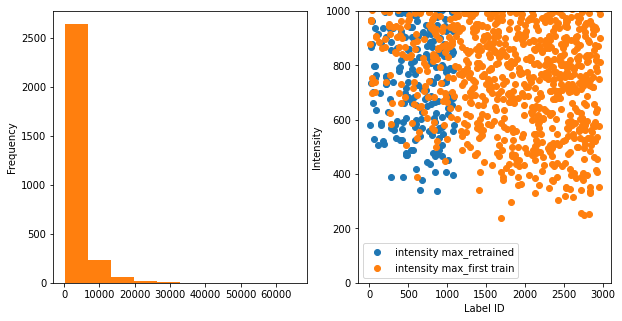

In [86]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

df.intensity_max.plot(kind='hist',label='intensity_max_Ness',ax=ax[0])
df_2.intensity_max.plot(kind='hist',label='intensity_max_Ali',ax=ax[0])

ax[1].scatter(df.label.values,df.intensity_max.values,label="intensity max_retrained")
ax[1].scatter(df_2.label.values,df_2.intensity_max.values,label="intensity max_first train")

plt.legend()
plt.ylim(0,1000)
plt.xlabel('Label ID')
plt.ylabel('Intensity')
plt.show()

In [29]:
print(np.max(df_2.intensity_max.values))

65535.0


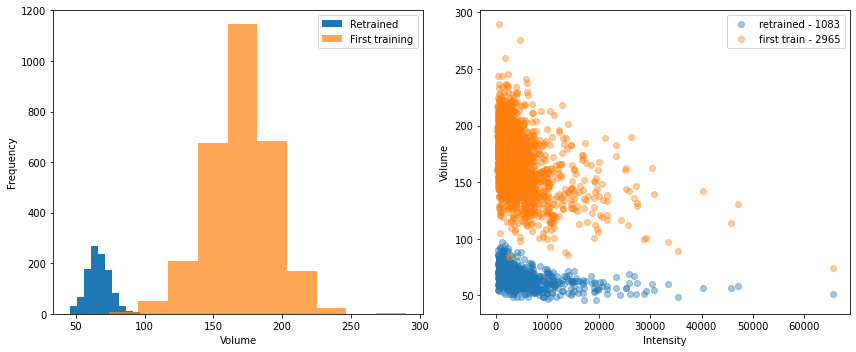

In [118]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,5)

df.area.plot(kind='hist',label='Retrained',ax=ax[0])
df_2.area.plot(kind='hist',label='First training',ax=ax[0],alpha=0.7)
ax[0].legend()
ax[0].set_xlabel('Volume')
#ax[0].set_xlim(0,1000)

ax[1].scatter(df.intensity_max.values,df.area.values,label=f"retrained - {len(df.intensity_max.values)}",alpha=0.4)
ax[1].scatter(df_2.intensity_max.values,df_2.area.values,label=f"first train - {len(df_2.intensity_max.values)}",alpha=0.4)
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Volume')
#ax[1].set_ylim(0,2000)

plt.legend()
plt.tight_layout()

plt.savefig('Plots/Retraining_2.svg',dpi=300)
plt.show()

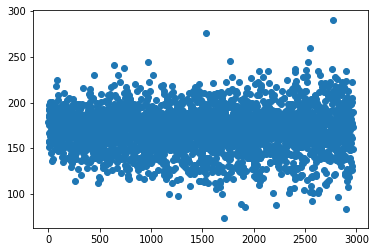

In [88]:
plt.scatter(df_2.label.values,df_2.area.values)

Ideas to move forward: 
- Start from the raw image and run starfind to detect the objects and get coordinates. See if those coordinates are also present in the labeled image (would be a measure of how many true points are detected by the network)
- Start from the labeled image and frome those coordinate in the raw image crop the raw image and display a montage of all the segmented points to see wether the network detectyed something real or not. We could also classify them by increasing intensity to make it more pretty